# Note on the Notebook

The examples in this notebook are inspired by real-world scenarios I've observed or experienced across different projects. They touch on several of the points discussed during the PoC to Production talk.

Each example is designed to:
- Work within the limitations of the free Gurobi restricted license, and  
- Fit within the time constraints of our session.

While the datasets and models here are much smaller than those used in production, the lessons, best practices, and pitfalls to avoid remain exactly the same.

In every example that follows, something is wrong.  
Your mission, should you choose to accept it, is to identify the culprit(s) using what you've learned so far.

**Happy debugging!**

# Install Required Packages

In [ ]:
%pip install gurobipy
%pip install pandas
# %pip install plotly

In [1]:
# Import packages
import math
import random
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import plotly.graph_objects as go

# Example 1: Assign Items to Resources
Replace *items* with orders, goods, products, groceries, food, or workers, and *resources* with trucks, buses, baskets, or boxes, and you'll start seeing this problem everywhere.

Any time you have a limited number of resources with finite capacity, and you need to place, match, assign, or pack your items into those resources, often with goals such as minimizing the number of resources used, you're dealing with a variation of the _bin packing problem_.

In [2]:
def ex1():
    # Load the data
    orders = pd.read_csv('ex1_orders.csv')
    vehicles = pd.read_csv('ex1_vehicles.csv')
    num_orders = len(orders)
    num_vehicles = len(vehicles)
    # Build the model
    model = gp.Model('vehicle_loading')
    # x[i,t]: 1 if order i assigned to vehicle t
    x = model.addVars(num_orders, num_vehicles, vtype=GRB.BINARY, name='x')
    # y[t]: 1 if vehicle t is used
    y = model.addVars(num_vehicles, vtype=GRB.BINARY, name='y')

    # Each order assigned to exactly one vehicle
    model.addConstrs((x.sum(i, '*') == 1 for i in range(num_orders)), name='assign')
    # vehicle capacity constraints
    model.addConstrs(
        (gp.quicksum(orders.loc[i, 'weight'] * x[i, t] for i in range(num_orders))
         <= vehicles.loc[t, 'capacity'] * y[t] for t in range(num_vehicles)), name='capacity')

    # Objective: minimize number of used vehicles
    model.setObjective(y.sum(), GRB.MINIMIZE)
    model.Params.OutputFlag = 0  # turn off the log
    model.optimize()
    if model.status == GRB.OPTIMAL:
        print(f'Optimal. Best Objective: {model.ObjVal}')
    elif model.status == GRB.INFEASIBLE:
        print('Infeasible!')
    else:
        print(f'Model Status: {model.status}')

In [4]:
ex1()

Infeasible!


# Solution 1: 
The model looks correct. You can also save it as an `.lp` file using `model.write('vehicle_loading.lp')` and inspect it if needed. Sometimes issues become clearer when you look at the generated model.

However, the first step, like any other problem, is to check the data. Doing so reveals that some orders have weights exceeding the vehicle capacity, which makes the model infeasible.

A simple safeguard is to validate your inputs before building the model, for example, by checking that no item exceeds the resource capacity.

In [ ]:
# Put this in the function, after reading the input data
# Validate the data
max_capacity = vehicles['capacity'].max()
invalid_orders = orders[orders['weight'] > max_capacity]
if not invalid_orders.empty:
    print(f'Max vehicle capacity is: {max_capacity}.\nInvalid orders:\n{invalid_orders}')
    print('\nFix the input data first, before running the model!')
    return

# Example 2: Unexpected Cost
You're working on a problem to determine the optimal flow of products between distribution centers (DCs) and customers, given supply and demand, with the goal of minimizing transportation cost.

You've been told that the current solution is around \\$6M, and the optimal solution of the model is expected not to exceed this value.  
However, the model's optimal solution is close to \\$8M. What do you think is going wrong?

In [5]:
def ex2():
    dcs_df = pd.read_csv('ex2_dcs.csv')
    cust_df = pd.read_csv('ex2_customers.csv')
    lanes_df = pd.read_csv('ex2_lanes.csv')
    # Built some objects for convenience and speed
    dc = dcs_df['dc_id'].tolist()
    cust = cust_df['cust_id'].tolist()
    arcs = list(lanes_df[['dc', 'cust']].itertuples(index=False, name=None))
    supply = dcs_df.set_index('dc_id')['supply'].to_dict()
    demand = cust_df.set_index('cust_id')['demand'].to_dict()
    cost = lanes_df.set_index(['dc', 'cust'])['cost'].to_dict()

    # Model
    model = gp.Model('transport')
    # x[d,c]: flow from dc d to customer c
    x = model.addVars(arcs, lb=0.0, vtype=GRB.CONTINUOUS, name='x')

    # supply constraints
    model.addConstrs((x.sum(d, '*') <= supply[d] for d in dc), name='supply')
    # demand constraints
    model.addConstrs((x.sum('*', c) >= demand[c] for c in cust), name='demand')
    # Objective: minimize total transport cost
    model.setObjective(gp.quicksum(cost[d, c] * x[d, c] for (d, c) in arcs), GRB.MINIMIZE)
    model.Params.OutputFlag = 0  # turn off the log
    model.optimize()
    if model.Status == GRB.OPTIMAL:
        print(f'Objective: {model.ObjVal:,.0f}')

In [6]:
ex2()

Objective: 7,909,174


# Solution 2:
This example also falls into the category of validating input data. However, unlike before, there's nothing obviously wrong with the values themselves.  
If you have the habit of doing exploratory data analysis (EDA), you may spot what's wrong much faster.  
This dataset contains some outliers that cause the numbers to spike. As you probably know, a good way to detect outliers is to visualize the data.

**In fact, visualization, if possible, is always a good rule of thumb, both for inputs and solutions.**

In this case, creating a simple map of the geographical locations can be very revealing. You'll notice that three of the customer locations are in Hawaii (HI).  
What the stakeholders didn't mention when giving you the \$6M benchmark is that customers in HI were out of scope!

In [7]:
def plot_ex2():
    dcs = pd.read_csv('ex2_dcs.csv')
    customers = pd.read_csv('ex2_customers.csv')
    fig = go.Figure()
    # Customers
    fig.add_trace(go.Scattermap(
        lat=customers["lat"], lon=customers["lon"],
        mode="markers",
        marker=dict(size=7),
        customdata=customers["cust_id"],
        hovertemplate="Customer %{customdata}<extra></extra>",
        # name="Customers",
        showlegend=False))

    # DCs
    fig.add_trace(go.Scattermap(
        lat=dcs["lat"], lon=dcs["lon"],
        mode="markers+text",
        marker=dict(size=18, symbol="triangle-up"),
        text=dcs["dc_id"],
        textposition="top center",
        textfont=dict(size=14),
        hoverinfo="skip",
        # name="DCs",
        showlegend=False))

    fig.update_layout(
        map=dict(
            style="open-street-map",
            zoom=2.2,
            center=dict(lat=36, lon=-100)),
        margin=dict(l=0, r=0, t=0, b=0),
        showlegend=False)
    fig.show()

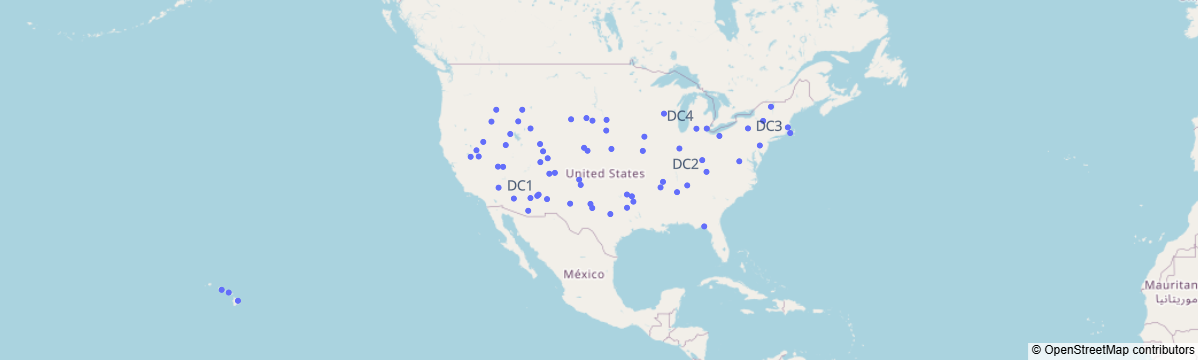

In [8]:
plot_ex2()

# Example 3: Why Infeasible?
There are situations where a set of tasks share limited resources, meaning some tasks cannot be executed simultaneously because they depend on or compete for the same resource. We can model this as a compatibility graph, where each task is a node and an edge between two tasks indicates that they have no conflict and can run in parallel. If there is no edge between two tasks (i.e., no compatibility), they cannot both be in the solution. The goal is to find the largest subset of mutually compatible tasks; those that can all be performed at the same time without resource overlap. This is known as the _maximum clique problem_.

This problem appears in social network analysis (e.g., finding the largest group of mutual friends), telecom, bioinformatics, manufacturing, and many other domains.

In the example below, find out why the function returns infeasible.

In [5]:
def ex3():
    # Using this to ensure all are working with the same data
    n, p, seed = 200, 0.95, 42
    random.seed(seed)
    edges = set()
    for i in range(n):
        for j in range(i + 1, n):
            if random.random() < p:
                edges.add((i, j))

    model = gp.Model('max_clique')
    model.Params.TimeLimit = 3
    model.Params.OutputFlag = 0

    x = model.addVars(n, vtype=GRB.BINARY, name='x')
    for i in range(n):
        for j in range(i + 1, n):
            if (i, j) not in edges:  # no edge, no compatibility
                model.addConstr(x[i] + x[j] <= 1, name=f'conflict_{i}_{j}')
    # Find the maximum set of compatible nodes
    model.setObjective(x.sum(), GRB.MAXIMIZE)
    model.optimize()
    if model.status == GRB.OPTIMAL:
        print(f'Optimal. Best Objective: {model.ObjVal}')
    else:
        print('Infeasible')

In [6]:
ex3()

Set parameter TimeLimit to value 3
Infeasible


# Solution 3:
This model cannot be solved within the 3-second time limit set by the parameter. Because of how the model is written, if the solution is not optimal, it mistakenly returns an "Infeasible" message.

So, what's a better approach? At the very least, you should handle the model's status more carefully:
- If the model is not **Optimal**, it can have several other statuses. At minimum, return the actual status to see what it is.
- Check for all relevant statuses that matter in your use case. For example, are you fine with returning the best feasible solution if the time limit is reached?
- If the model is genuinely **Infeasible**, do you simply want to return that message, or handle it differently?

Bottom line:  
**Always check against all the solver statuses that may occur in your model, based on your configuration.**

In [ ]:
# Example of a different process for status. Replace the end of ex3() function with this.
if model.status == GRB.OPTIMAL:
    print(f'Optimal. Best Objective: {model.ObjVal}')
elif model.status == GRB.TIME_LIMIT:
    # CAUTION: Timelimit may be reached and still no feasible solution is found.
    # It's best to check the model for solution values that'll be populated in case of feasibility.
    obj_val = model.ObjVal if hasattr(model, 'ObjVal') else 'Not Found'
    print(f'Timelimit has reached. The best feasible solution objective: {obj_val}')
elif model.status == GRB.INFEASIBLE:
    # Better to have a mechanism to deal with this.
    # e.g., ComputeIIS or another model that's triggered in these cases
    print('Infeasible')
else:
    print(f'Model Status for investigation: {model.status}')

# Example 4: Non-Integer Integers! 
This small model looks straightforward with two integer variables.
But when you look at the optimal values, something seems off. What's going on?

In [7]:
def ex4():
    model = gp.Model()
    x = model.addVar(vtype=GRB.INTEGER, ub=1000, name="x")
    y = model.addVar(vtype=GRB.INTEGER, ub=1000, name="y")
    # max πx + ey
    model.setObjective(math.pi * x + math.e * y, GRB.MAXIMIZE)
    model.addConstr(math.pi * x + 1 / 3 * y <= 3141.59265)
    model.addConstr(x + y <= 1000)
    model.Params.OutputFlag = 0
    model.optimize()
    if model.Status == GRB.OPTIMAL:
        print(f'Optimal Solution: {model.ObjVal}')
        for v in model.getVars():
            print(v.VarName, v.X)

In [8]:
ex4()

Optimal Solution: 3141.5926529489225
x 999.9999987232932
y 1.2397618199993859e-06


# Solution 4:
The "non-integer" values in the solution are actually integer-feasible within Gurobi's tolerance. By default, Gurobi's integer feasibility tolerance ([IntFeasTole](https://docs.gurobi.com/projects/optimizer/en/current/reference/parameters.html#intfeastol)) is 1e-5. 

In this example, both `x` and `y` are within the tolerance and thus count as integer-feasible. 
If you need stricter integer precision, you can tighten the `IntFeasTol` parameter to a smaller value.

When reporting results, you might choose to round integer values for clarity, but be careful.
A **common mistake** is using exact equality checks for **binary variables**, such as `v.X == 1` or `v.X == 0`.
As seen in this example with integer values, solver tolerances can produce results like 0.999999 or 1.2e-6.
Using direct equality tests can misclassify such variables.
Instead, use a tolerance-aware check, treat a binary variable as 1 if `v.X > 0.5`.

When you enable the Gurobi log output, you may also notice that the solver reports two feasible solutions.
You can inspect the alternative feasible solution using Gurobi's solution pool features as shown below.

In [9]:
def ex4_solution():
    model = gp.Model()
    x = model.addVar(vtype=GRB.INTEGER, ub=1000, name="x")
    y = model.addVar(vtype=GRB.INTEGER, ub=1000, name="y")
    # max πx + ey
    model.setObjective(math.pi * x + math.e * y, GRB.MAXIMIZE)
    model.addConstr(math.pi * x + 1 / 3 * y <= 3141.59265)
    model.addConstr(x + y <= 1000)
    # model.Params.OutputFlag = 0  # Extra: Turn it on. Look at solution count
    model.Params.IntFeasTol = 1e-9  # Something to play with. What happens? Why?
    model.optimize()
    if model.Status == GRB.OPTIMAL:
        # This part is extra and unrelated. Just want to show you how to check the solutions of the solution pool.
        for k in range(model.SolCount):
            model.Params.SolutionNumber = k
            print(f'Solution {k}: obj={model.PoolObjVal}')
            for v in model.getVars():
                print(v.VarName, v.Xn)

In [51]:
ex4_solution()

Set parameter IntFeasTol to value 1e-05
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

WLS license 945452 - registered to Decision Spot
Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0x55387b9a
Variable types: 0 continuous, 2 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-01, 3e+00]
  Objective range  [3e+00, 3e+00]
  Bounds range     [1e+03, 1e+03]
  RHS range        [1e+03, 3e+03]
Found heuristic solution: objective 3141.1693428
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros
Variable types: 0 continuous, 2 integer (0 binary)

Root relaxation: objective 3.141593e+03, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf

# Example 5: Unexpected Solution
We're revisiting Example 2, but with a new constraint.  
This time, we want to decide which DCs to open and determine the flow of products from the open DCs to customers, given supply and demand, to minimize total cost (transportation + fixed opening costs).

But the optimal solution is totally unexpected. See if you can find out why.

In [10]:
def ex5():
    dcs_df = pd.read_csv('ex2_dcs.csv')
    cust_df = pd.read_csv('ex2_customers.csv')
    lanes_df = pd.read_csv('ex2_lanes.csv')

    # Built some objects for convenience and speed
    dc = dcs_df['dc_id'].tolist()
    cust = cust_df['cust_id'].tolist()
    arcs = list(lanes_df[['dc', 'cust']].itertuples(index=False, name=None))
    supply = dcs_df.set_index('dc_id')['supply'].to_dict()
    dem_max = cust_df.set_index('cust_id')['demand'].to_dict()
    dem_min = cust_df.set_index('cust_id')['min_demand'].to_dict()
    cost = lanes_df.set_index(['dc', 'cust'])['cost'].to_dict()

    # Model
    model = gp.Model('facility_location')
    # x[d,c]: flow from dc d to customer c
    x = model.addVars(arcs, lb=0.0, vtype=GRB.CONTINUOUS, name='x')
    # y[d]: 1 if dc d is open
    y = model.addVars(dc, vtype=GRB.BINARY, name='y')

    # per customer: min_demand[c] <= sum_d x[d,c] <= demand[c]
    model.addConstrs((x.sum('*', c) >= dem_min[c] for c in cust), name='min_demand')
    model.addConstrs((x.sum('*', c) <= dem_max[c] for c in cust), name='max_demand')

    # dc capacity: sum_c x[d,c] <= supply[d] * y[d]
    model.addConstrs((x.sum(d, '*') <= supply[d] * y[d] for d in dc), name='capacity')

    # Objective: shipping + fixed cost of opening a dc
    shipping = gp.quicksum(cost[d, c] * x[d, c] for (d, c) in arcs)
    fixed = 10_000 * y.sum()
    model.setObjective(shipping + fixed, GRB.MINIMIZE)
    model.Params.OutputFlag = 0
    model.optimize()
    if model.Status == GRB.OPTIMAL:
        print(f'Objective value: {model.ObjVal:.0f}')
        print(f'Facilities opened: {sum(int(round(y[d].X)) for d in dc)}')
        print(f'Total shipped: {sum(x[arc].X for arc in arcs):.0f}')

In [11]:
ex5()

Objective value: 0
Facilities opened: 0
Total shipped: 0


# Solution 5:
The model looks correct, and the data also seems fine at first glance. So, what's the issue?

In this case, it's a combination of both the input data and how the model is written:
- For each customer, the model enforces that the total demand served is between the minimum and maximum demand.  
- Each open DC cannot ship more than its available supply.  
- The objective is to minimize total cost.  
- However, the minimum demand for all customers is set to 0.

Fulfilling a demand of 0 for every customer is really easy. No DC needs to open, and no shipping is required. Problem solved!

If you set the minimum demand of even one customer to a positive value, you'll immediately see the model produce a more realistic and meaningful solution.

# Example 6: Another Unexpected Solution
Let's look at a simplified version of the facility location problem. Our goal is to decide how many facilities to open and how much to ship from each one to meet total demand at the lowest possible cost.

The model appears correct, and the solution is reported as optimal,  but something isn't right. Can you figure out what's happening?

_Hint_: It's not related to `model.Params.Presolve = 0`. We turned presolve off intentionally to make sure the issue shows up. In a small model like this, Gurobi's presolve is smart enough that if it were on, the model would solve without showing the problem.

In [13]:
def ex6():
    num_facilities = 3
    demand = 100
    shipping_cost = 1
    facility_cost = 5000
    M = 1e8

    model = gp.Model()
    model.Params.Presolve = 0
    # Quantity to ship from each facility
    x = model.addVars(num_facilities, name="ship")
    # Whether or not we open a facility
    y = model.addVars(num_facilities, vtype=GRB.BINARY, name="open_facility")
    # Satisfy customer demand
    model.addConstr(x.sum() == demand)
    # Only ship if facility is open
    for i in range(num_facilities):
        model.addConstr(x[i] <= M * y[i])
    # Minimize shipping costs + facility-opening costs
    model.setObjective(shipping_cost * x.sum() + facility_cost * y.sum(), GRB.MINIMIZE)
    model.optimize()
    if model.Status == GRB.OPTIMAL:
        for v in model.getVars():
            print(v.VarName, v.X)

In [14]:
ex6()

Set parameter Presolve to value 0
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
Presolve  0

WLS license 945452 - registered to Decision Spot
Optimize a model with 4 rows, 6 columns and 9 nonzeros
Model fingerprint: 0xc27b7ec5
Variable types: 3 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 1e+02]
Variable types: 3 continuous, 3 integer (3 binary)
Found heuristic solution: objective 15100.000000

Root relaxation: objective 1.000050e+02, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | 

# Solution 6:
The problem is the large M value relative to the solver's integrality tolerance that produces incorrect results.  
Here, `x` can take a positive value when `y` is zero, which contradicts the constraint that `x` should only be non-zero when `y=1`. This is an example of a trickle flow.

**What to do?**  
- **Use the Smallest Sufficient M**: Ensure M is large enough to satisfy constraints but avoid arbitrarily large values.
- **Use Indicator Constraints** (of the form $𝑦=0 \Rightarrow 𝑥=0$).
  - Constraints are easier to create. It's closer to how you think about a logical constraint.
  - Solver may be able to leverage the implicit knowledge of what a constraint does in the solving process and be able to produce a tighter value of M than you. This means, they are more numerically stable. Although they may come at the expense of additional processing time.
- If you need stricter integer precision, you can tighten the `IntFeasTol` parameter to a smaller value or use the [IntegralityFocus](https://docs.gurobi.com/projects/optimizer/en/current/reference/parameters.html#integralityfocus) parameter.

These options are explored as shown below.

In [27]:
def ex6_solution():
    num_facilities = 3
    demand = 100
    shipping_cost = 1
    facility_cost = 5000
    M = 1000  # smaller Big M

    model = gp.Model()
    model.Params.Presolve = 0
    # Quantity to ship from each facility
    x = model.addVars(num_facilities, name="ship")
    # Whether or not we open a facility
    y = model.addVars(num_facilities, vtype=GRB.BINARY, name="open_facility")
    # Satisfy customer demand
    model.addConstr(x.sum() == demand)
    # Only ship if facility is open. Using indicator constraints
    for i in range(num_facilities):
        model.addConstr(x[i] <= M * y[i])  # use a smaller Big M
        # model.addConstr((y[i] == 0) >> (x[i] == 0))  # or indicator
        # model.addGenConstrIndicator(y[i], 0, x[i] == 0)  # or indicator, but this way
    # Minimize shipping costs + facility-opening costs
    model.setObjective(shipping_cost * x.sum() + facility_cost * y.sum(), GRB.MINIMIZE)
    # model.Params.IntegralityFocus = 1  # you can play with the same large M value as before, but activating this parameter
    model.optimize()
    if model.Status == GRB.OPTIMAL:
        for v in model.getVars():
            print(v.VarName, v.X)

In [28]:
ex6_solution()

Set parameter Presolve to value 0
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11+.0 (26200.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1185G7 @ 3.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
Presolve  0

WLS license 945452 - registered to Decision Spot
Optimize a model with 4 rows, 6 columns and 9 nonzeros
Model fingerprint: 0x62489788
Variable types: 3 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 1e+02]
Variable types: 3 continuous, 3 integer (3 binary)
Found heuristic solution: objective 15100.000000

Root relaxation: objective 6.000000e+02, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | 

# Other Cautionary Tales
Here, we share additional examples, cautionary tales, and best practices to keep in your toolkit as you move from simple notebooks toward production-ready code.

## Failure After Project Handoff
- If you can't have unit tests for your code, at least deliver it with a few small datasets (in text formats like CSV or JSON that are version-controlled) that run successfully with your model. These act as your basic tests.
- If someone modifies the model and later reports an issue, you can rerun your small test dataset first to check whether it still passes. This helps you isolate whether the problem lies in the code or in the new data.

## Data-Specific Rules
- It's rare to build a model that runs only once and on a single dataset. Different datasets may include their own rules or hidden constraints that aren't obvious at first.
- Your model might run perfectly on one dataset and fail on another because of these differences.
- **Test your model on multiple datasets that capture the diversity of the system you're modeling.**
